###Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 100 decision trees
# random_state=42
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Model
print("Training Random Forest (this may take a few seconds)...")
rf_model.fit(X_train, y_train)
Data Preprocessing

[ ]
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Copy of Dementia Prediction Dataset.csv')

# Define Feature
cat_cols = [
    'TOBAC30', 'TOBAC100', 'ALCOCCAS', 'INRELTO', 'INLIVWTH',
    'INSEX', 'NACCNIHR', 'INRACE', 'INHISP',
    'INVISITS', 'INCALLS', 'ALCFREQ', 'INRELY'
]

# Numeric
num_cols = ['SMOKYRS', 'PACKSPER', 'QUITSMOK', 'NACCAGE', 'INEDUC']

# Cleaning

df['Dementia_Risk'] = df['CDRGLOB'].apply(lambda x: 0 if x == 0 else 1)

# Replace codes with NaNs
special_codes = [-4, 9, 99, 999, 88, 888]
df_clean = df.replace(special_codes, np.nan)


# Fill Nans with 0
for col in num_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(0)

# Fill Categorical Nans with -1
for col in cat_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(-1)

# Feature Engineering
if 'EDUC' in df.columns:
    df_clean['AGE_x_EDUC'] = df_clean['NACCAGE'] * df_clean['EDUC'].fillna(0)


df_final = pd.get_dummies(df_clean[num_cols + cat_cols + ['Dementia_Risk', 'AGE_x_EDUC']],
                          columns=cat_cols,
                          drop_first=True)

# Convert Booleans to Ints
df_final = df_final.astype(float)

# Sanity Check
print(f"Processed Shape: {df_final.shape}")
print("Check for 'True/False':", df_final.select_dtypes(include='bool').columns.tolist())
print("First 5 rows:")
df_final.head()

# Save
df_final.to_csv('engineered_dementia_data.csv', index=False)
/tmp/ipython-input-2555289108.py:5: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Copy of Dementia Prediction Dataset.csv')
Processed Shape: (195196, 60)
Check for 'True/False': []
First 5 rows:

[ ]
display(df_final.isnull().sum())

[ ]
df_final.head(20)

[ ]
from google.colab import drive
drive.mount('/content/drive')
Data splitting

[ ]
from sklearn.model_selection import train_test_split

# 1. Define X  and y
# Drop the target
X = df_final.drop(columns=['Dementia_Risk'])
y = df_final['Dementia_Risk']

# 2. Split the data
# Stratify=y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape of Training Data:", X_train.shape)
print("Shape of Test Data:", X_test.shape)
Shape of Training Data: (156156, 59)
Shape of Test Data: (39040, 59)

[ ]
# counts 0 vs 1
print("Target distribution in Training Set:")
print(y_train.value_counts(normalize=True))

# Calculate Null Accuracy
most_frequent_class = y_train.mode()[0]
null_accuracy = y_test.value_counts(normalize=True)[most_frequent_class]

print(f"\n--- BASELINE TO BEAT ---")
print(f"If we just guessed '{most_frequent_class}' for everyone, we would get: {null_accuracy:.2%} accuracy.")
print(f"Your AI model MUST score higher than {null_accuracy:.2%} to be useful.")
Target distribution in Training Set:
Dementia_Risk
1.0    0.520377
0.0    0.479623
Name: proportion, dtype: float64

--- BASELINE TO BEAT ---
If we just guessed '1.0' for everyone, we would get: 52.04% accuracy.
Your AI model MUST score higher than 52.04% to be useful.
Scale the data

[ ]
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Scale the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Scaled successfully.")

# make Model
# random_state=42
log_reg = LogisticRegression(random_state=42, max_iter=1000)

#Train the Model
print("Training Logistic Regression...")
log_reg.fit(X_train_scaled, y_train)

#Predicting
y_pred_log = log_reg.predict(X_test_scaled)

#Evaluate
log_accuracy = accuracy_score(y_test, y_pred_log)

print(f"\n--- Logistic Regression Results ---")
print(f"Accuracy: {log_accuracy:.2%}")
print(f"Baseline to Beat: 52.04%")
print("\nDetailed Report:\n")
print(classification_report(y_test, y_pred_log))
Data Scaled successfully.
Training Logistic Regression...

--- Logistic Regression Results ---
Accuracy: 63.68%
Baseline to Beat: 52.04%

Detailed Report:

              precision    recall  f1-score   support

         0.0       0.64      0.55      0.59     18724
         1.0       0.63      0.71      0.67     20316

    accuracy                           0.64     39040
   macro avg       0.64      0.63      0.63     39040
weighted avg       0.64      0.64      0.63     39040

Random Forest

[ ]

#Predicting
y_pred_rf = rf_model.predict(X_test)

#Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\n--- Random Forest Results ---")
print(f"Accuracy: {rf_accuracy:.2%}")
print(f"Previous Best (LogReg): {log_accuracy:.2%}")
print("\nDetailed Report:\n")
print(classification_report(y_test, y_pred_rf))

Training Random Forest (this may take a few seconds)...

--- Random Forest Results ---
Accuracy: 66.42%
Previous Best (LogReg): 63.68%

Detailed Report:

              precision    recall  f1-score   support

         0.0       0.65      0.64      0.65     18724
         1.0       0.68      0.68      0.68     20316

    accuracy                           0.66     39040
   macro avg       0.66      0.66      0.66     39040
weighted avg       0.66      0.66      0.66     39040



###Top predictor identifyinng

/tmp/ipython-input-2114650190.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


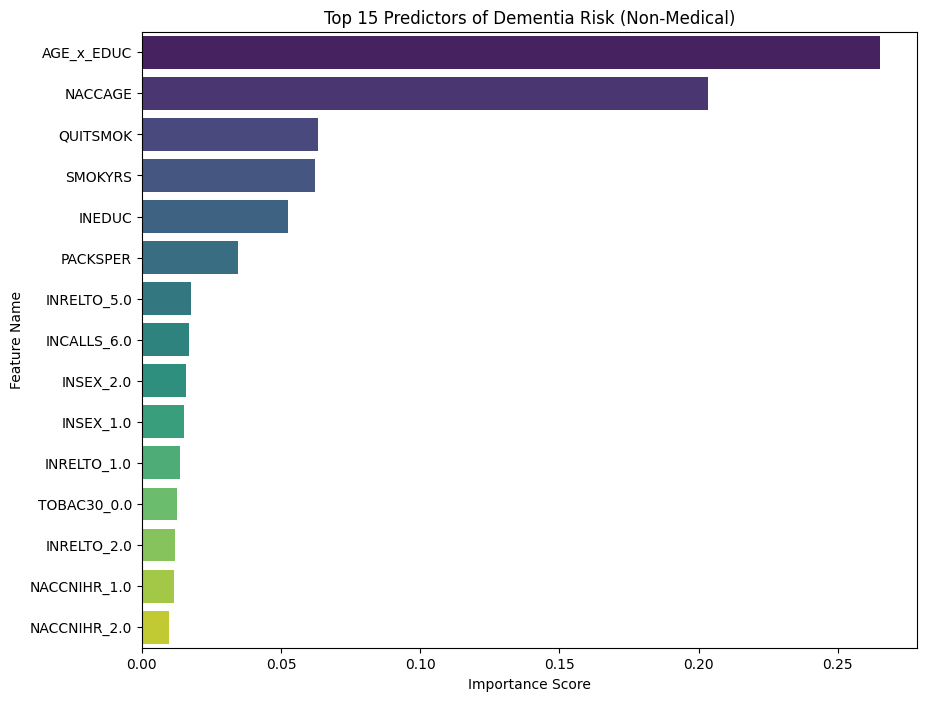

Top 10 Most Important Features:
        Feature  Importance
5    AGE_x_EDUC    0.265068
3       NACCAGE    0.203284
2      QUITSMOK    0.063453
0       SMOKYRS    0.062233
4        INEDUC    0.052540
1      PACKSPER    0.034430
16  INRELTO_5.0    0.017776
49  INCALLS_6.0    0.016977
22    INSEX_2.0    0.015899
21    INSEX_1.0    0.015216


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# get the Importance scores
importances = rf_model.feature_importances_

# map scores
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#Plot Features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Predictors of Dementia Risk (Non-Medical)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()

#print the raw list
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

###Identified the most importent features

AGE_x_EDUC
NACCAGE
QUITSMOK, SMOKYRS, PACKSPER

###Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# grid
param_grid = {
    'n_estimators': [100, 200],       # number of trees
    'max_depth': [None, 10, 20],      # deep
    'min_samples_split': [2, 5],      # minimum samples
    'class_weight': ['balanced', None] #class balance
}

#Cross Validation
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# run the Search
print("Starting Hyperparameter Tuning (this may take a few minutes)...")
grid_search.fit(X_train, y_train)

# best Results
print(f"\n--- Best Parameters Found ---")
print(grid_search.best_params_)

# evaluate
best_rf = grid_search.best_estimator_
best_accuracy = accuracy_score(y_test, best_rf.predict(X_test))

print(f"\nOptimized Accuracy: {best_accuracy:.2%}")
print(f"Improvement over Base Model: {best_accuracy - rf_accuracy:.2%}")

Starting Hyperparameter Tuning (this may take a few minutes)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- Best Parameters Found ---
{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Optimized Accuracy: 67.27%
Improvement over Base Model: 0.85%


###Check Overfitting

Final Model Report Card:
Training Accuracy: 77.22% (Did it memorize?)
Test Accuracy:     67.27% (Real-world performance)
Gap:               9.95%


<Figure size 800x600 with 0 Axes>

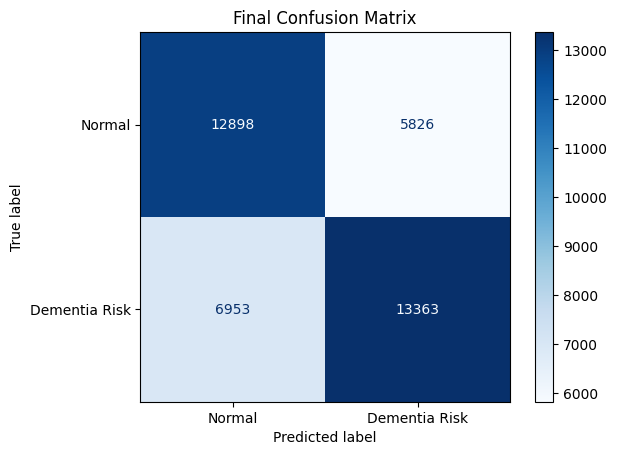

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# get the best model
final_model = grid_search.best_estimator_

# calculate scores
train_acc = accuracy_score(y_train, final_model.predict(X_train))
test_acc = accuracy_score(y_test, final_model.predict(X_test))

print(f"Final Model Report Card:")
print(f"Training Accuracy: {train_acc:.2%} ()")
print(f"Test Accuracy:     {test_acc:.2%} ()")
print(f"Gap:               {train_acc - test_acc:.2%}")

#visualise the matrix
cm = confusion_matrix(y_test, final_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Dementia Risk'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Final Confusion Matrix')
plt.show()

In [ ]:
###Gradient Boosting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# load Data
df = pd.read_csv('/content/drive/MyDrive/Copy of Dementia Prediction Dataset.csv')

# feature Lists

potential_cat_cols = [
    'TOBAC30', 'TOBAC100', 'ALCOCCAS', 'INRELTO', 'INLIVWTH',
    'INSEX', 'NACCNIHR', 'INRACE', 'INHISP',
    'INVISITS', 'INCALLS', 'ALCFREQ', 'INRELY'
]
potential_num_cols = ['SMOKYRS', 'PACKSPER', 'QUITSMOK', 'NACCAGE', 'INEDUC', 'EDUC']

# Preprocessing and Cleaning
# Target
if 'CDRGLOB' in df.columns:
    df['Dementia_Risk'] = df['CDRGLOB'].apply(lambda x: 0 if x == 0 else 1)
else:
    print("Error: Target column 'CDRGLOB' not found!")

# Replace specials with NaNs
df_clean = df.replace([-4, 9, 99, 999, 88, 888], np.nan)

# Identify which columns are actually present in your file
valid_cat = [c for c in potential_cat_cols if c in df_clean.columns]
valid_num = [c for c in potential_num_cols if c in df_clean.columns]

# handle missing Values
for col in valid_num:
    df_clean[col] = df_clean[col].fillna(0)
for col in valid_cat:
    df_clean[col] = df_clean[col].fillna(-1)

# feature Engineering
# ---------------------------------------------------------
if 'NACCAGE' in df_clean.columns:
    if 'EDUC' in df_clean.columns:
        df_clean['AGE_x_EDUC'] = df_clean['NACCAGE'] * df_clean['EDUC']
    elif 'INEDUC' in df_clean.columns:
        print("Note: Using Caregiver Education (INEDUC) as proxy for Socioeconomic Status.")
        df_clean['AGE_x_EDUC'] = df_clean['NACCAGE'] * df_clean['INEDUC']

# One Hot Encoding
features_to_use = valid_num + valid_cat
if 'AGE_x_EDUC' in df_clean.columns:
    features_to_use.append('AGE_x_EDUC')

df_final = pd.get_dummies(df_clean[features_to_use + ['Dementia_Risk']],
                          columns=valid_cat,
                          drop_first=True)

# train-Test Split
X = df_final.drop(columns=['Dementia_Risk'])
y = df_final['Dementia_Risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# final train Gradient Boosting
print("Training Gradient Boosting Model...")
gb_model = GradientBoostingClassifier(
    n_estimators=200,    # Build 200 trees
    learning_rate=0.1,   # Learn slowly (better for precision)
    max_depth=4,         # Slightly deeper trees
    random_state=42
)
gb_model.fit(X_train, y_train)

# Results
gb_acc = accuracy_score(y_test, gb_model.predict(X_test))
print(f"\n--- FINAL RESULTS ---")
print(f"Gradient Boosting Accuracy: {gb_acc:.2%}")
# Comparin previous best of 67.27%
print(f"Improvement over Random Forest: {gb_acc - 0.6727:.2%}")

/tmp/ipython-input-3303170954.py:8: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Copy of Dementia Prediction Dataset.csv') # <--- UPDATE THIS FILENAME


Training Gradient Boosting Model...

--- FINAL RESULTS ---
Gradient Boosting Accuracy: 66.26%
Improvement over Random Forest: -1.01%


###Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier

# Best Models
rf_best = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    class_weight='balanced',
    random_state=42
)

gb_best = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# create the voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf_best), ('gb', gb_best)],
    voting='soft'
)

# train the Committee
print("Training the Ensemble Model (Committee)...")
voting_clf.fit(X_train, y_train)

# final Evaluation
final_predictions = voting_clf.predict(X_test)
final_acc = accuracy_score(y_test, final_predictions)

print(f"\n--- GRAND FINALE RESULTS ---")
print(f"Ensemble Accuracy: {final_acc:.2%}")
print(f"Compare to Random Forest: 67.27%")

Training the Ensemble Model (Committee)...

--- GRAND FINALE RESULTS ---
Ensemble Accuracy: 67.31%
Compare to Random Forest: 67.27%
